In [96]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import hdbscan
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [97]:
# --- CARGAR EL DATASET ---
df = pd.read_csv("limpieza_y_extraccion_de_datos/datasets/startups_para_modelar.csv", sep=",")

In [98]:
# --- NORMALIZACIÓN Y CODIFICACIÓN DE VARIABLES ---

# Variables para transformación logarítmica
log_vars = [
    'financiacion_total_por_acciones', 'ultima_financiacion_por_acciones',
    'monto_de_ultima_financiacion', 'financiacion_total',
    'seguidores_en_linkedin', 'seguidores_en_facebook', 'seguidores_en_twitter',
    'empleados_en_linkedin'
    
    , 'años_desde_ultima_financiacion'
]

# Asegurar tipos numéricos
df[log_vars] = df[log_vars].apply(pd.to_numeric, errors='coerce')

# Crear columnas logarítmicas
for col in log_vars:
    df[f"{col}_log"] = np.log1p(df[col])

In [99]:
# Variables numéricas
num_vars = [
    'numero_de_marcas_registradas', 'numero_de_patentes_otorgadas',
    'numero_total_de_fundadores', 'numero_de_mujeres_fundadores',
    'numero_de_hombres_fundadores', 'numero_de_inversionistas',
    'numero_de_inversionistas_principales', 'numero_de_inversiones_en_rondas_de_financiacion',
    'numero_de_articulos', 'numero_de_rondas_de_financiacion',
    'antiguedad_de_la_empresa'
] + [f"{col}_log" for col in log_vars]


In [100]:
# Variables categóricas
cat_vars = ['categoria', 'tipo_de_ultima_financiacion']

In [101]:
# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vars),
       ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_vars)
    ]
)

In [102]:
#--- TRANSFORMACIÓN ---
X = preprocessor.fit_transform(df)

In [103]:
# --- GUARDAR EL CONJUNTO DE DATOS NORMALIZADO ---

# Crear carpeta si no existe
output_dir = "datasets_generados_por_modelado"
os.makedirs(output_dir, exist_ok=True)

# Nombres de columnas resultantes
num_names = num_vars
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_vars).tolist()
column_names = num_names + cat_names

# Convertir a DataFrame final si lo deseas
X_df = pd.DataFrame(X, columns=column_names)

X_df.to_csv(output_dir+"/df_normalizado.csv", index=False)

In [104]:
# --- EJECUTAR LOS MODELOS DE ESTUDIO --- 

# Diccionario para almacenar resultados
resultados = {}

# Valor de K obtenido a estudio de los métodos Silhouette, Calinski-Harabasz y Davies-Bouldin
K = 2

# K-MEANS
#kmeans = KMeans(n_clusters=K, random_state=42)
kmeans = KMeans(n_clusters=K,random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(X)


resultados['KMeans'] = {
    'Silhouette': silhouette_score(X, labels_kmeans),
    'Calinski-Harabasz': calinski_harabasz_score(X, labels_kmeans),
    'Davies-Bouldin': davies_bouldin_score(X, labels_kmeans)
}

# GMM
gmm = GaussianMixture(n_components=K, random_state=42)
labels_gmm = gmm.fit_predict(X)

resultados['GMM'] = {
    'Silhouette': silhouette_score(X, labels_gmm),
    'Calinski-Harabasz': calinski_harabasz_score(X, labels_gmm),
    'Davies-Bouldin': davies_bouldin_score(X, labels_gmm)
}

# HDBSCAN
hdbscan_model =  hdbscan.HDBSCAN(min_cluster_size=5)
#hdb = hdbscan.HDBSCAN(min_cluster_size=25, min_samples=15)
labels_hdbscan = hdbscan_model.fit_predict(X)

# Filtrar outliers etiquetados como -1
mask = labels_hdbscan != -1
if np.unique(labels_hdbscan[mask]).size > 1:
    resultados['HDBSCAN'] = {
        'Silhouette': silhouette_score(X[mask], labels_hdbscan[mask]),
        'Calinski-Harabasz': calinski_harabasz_score(X[mask], labels_hdbscan[mask]),
        'Davies-Bouldin': davies_bouldin_score(X[mask], labels_hdbscan[mask])
    }
else:
    resultados['HDBSCAN'] = {
        'Silhouette': None,
        'Calinski-Harabasz': None,
        'Davies-Bouldin': None
    }

# 7. Mostrar resultados
print("Evaluación de calidad de clústeres:\n")
for metodo, metricas in resultados.items():
    print(f"--- {metodo} ---")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}" if valor is not None else f"{metrica}: No disponible")
    print()


Evaluación de calidad de clústeres:

--- KMeans ---
Silhouette: 0.2058
Calinski-Harabasz: 193.9729
Davies-Bouldin: 1.6697

--- GMM ---
Silhouette: 0.1493
Calinski-Harabasz: 83.1510
Davies-Bouldin: 2.4992

--- HDBSCAN ---
Silhouette: 0.2295
Calinski-Harabasz: 19.3224
Davies-Bouldin: 1.3301



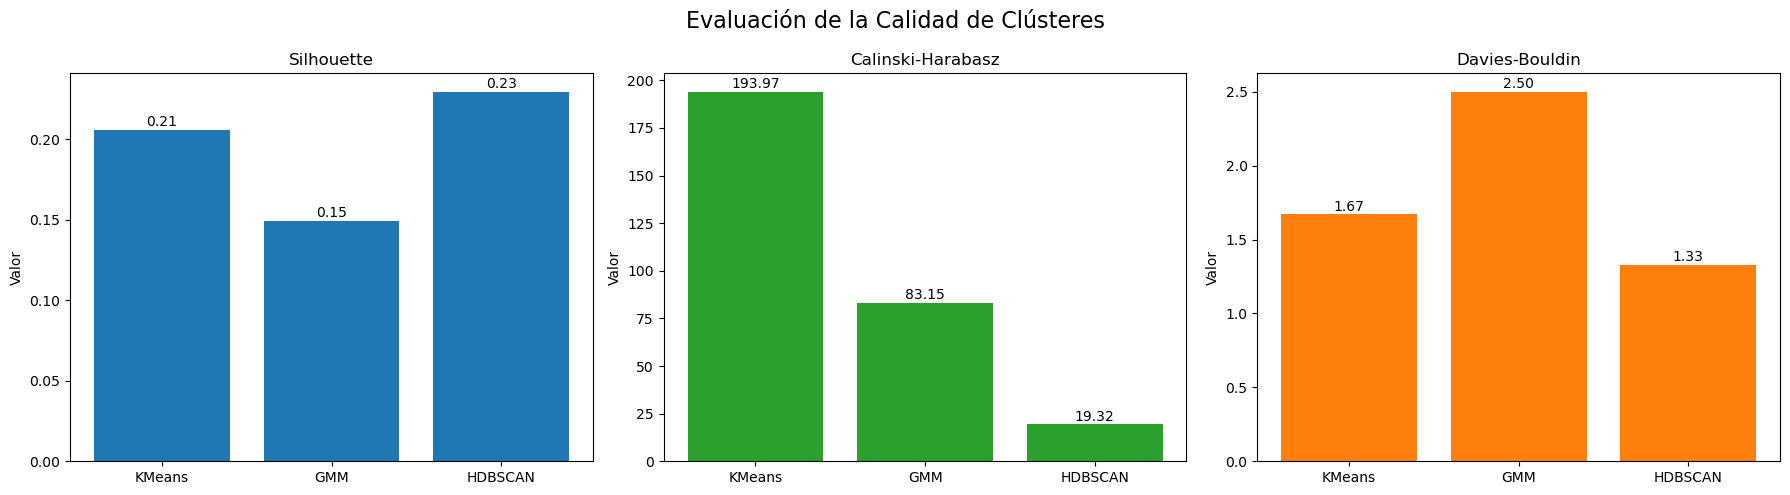

In [105]:
# --- GRÁFICA COMPARATIVAS ---
metodos = list(resultados.keys())
metricas = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']

# Extraer valores
valores = {metrica: [resultados[metodo][metrica] if resultados[metodo][metrica] is not None else 0 for metodo in metodos] for metrica in metricas}

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Evaluación de la Calidad de Clústeres", fontsize=16)

colores = ['#1f77b4', '#2ca02c', '#ff7f0e']

for i, metrica in enumerate(metricas):
    axs[i].bar(metodos, valores[metrica], color=colores[i])
    axs[i].set_title(metrica)
    axs[i].set_ylabel("Valor")
    axs[i].set_ylim(bottom=0)
    for j, v in enumerate(valores[metrica]):
        axs[i].text(j, v + 0.01 * max(valores[metrica]), f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()


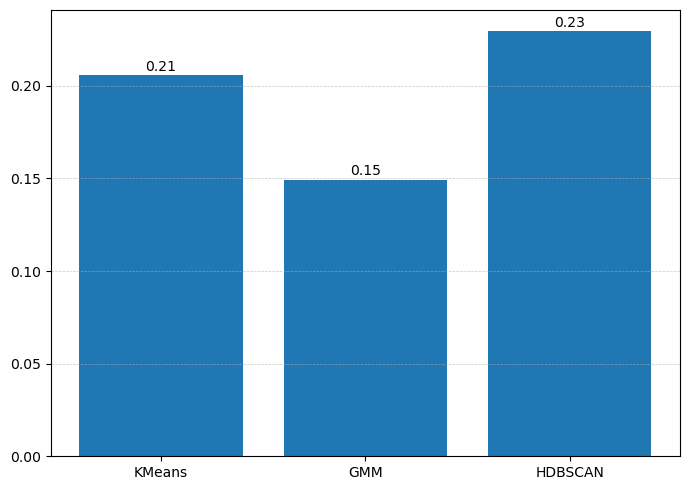

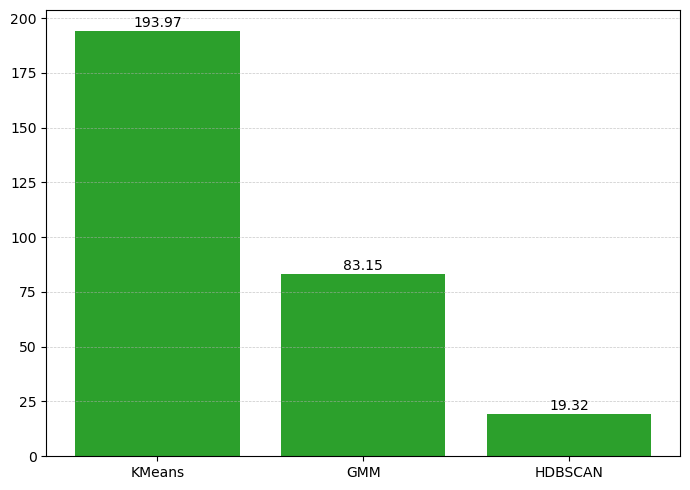

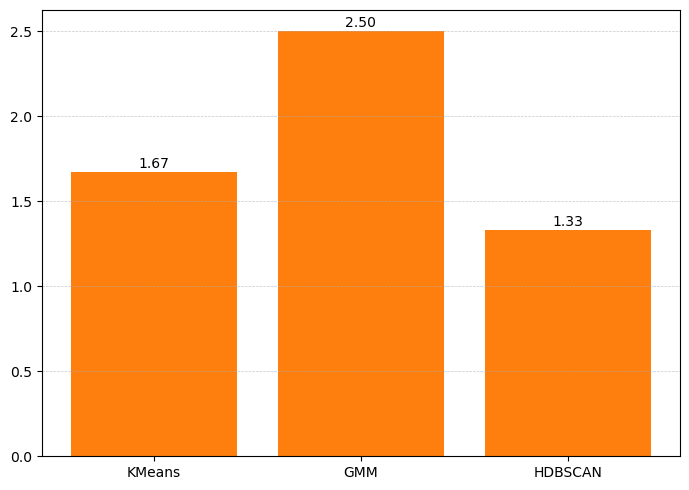

In [106]:
# --- SE GENERAN GRÁFICAS PARA EL TRABAJO ESCRITO --- 

# Crear carpeta si no existe
output_dir = "comparativa_grafica_por_algoritmo"
os.makedirs(output_dir, exist_ok=True)

# Colores para cada métrica
colores = {
    'Silhouette': '#1f77b4',
    'Calinski-Harabasz': '#2ca02c',
    'Davies-Bouldin': '#ff7f0e'
}

# Crear una figura por métrica
for metrica in metricas:
    plt.figure(figsize=(7, 5))
    plt.bar(metodos, valores[metrica], color=colores[metrica])
    #plt.title(f"{metrica} Score")
    #plt.ylabel("Valor")
    plt.ylim(bottom=0)
    
    # Añadir etiquetas de valor encima de cada barra
    for i, v in enumerate(valores[metrica]):
        plt.text(i, v + 0.01 * max(valores[metrica]), f"{v:.2f}", ha='center')

    # Guardar la gráfica (opcional)
    #plt.savefig('comparativa_grafica_por_algoritmo/'+f"{metrica.lower().replace('-', '_')}_score.png", dpi=300, bbox_inches='tight')

     # Guardar imagen
    path = os.path.join(output_dir, f"{metrica.lower().replace('-', '_')}_score.png")
    plt.savefig(path, dpi=300, bbox_inches='tight')
       
    
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

C:\Users\davis\.conda\envs\TF\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\davis\.conda\envs\TF\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


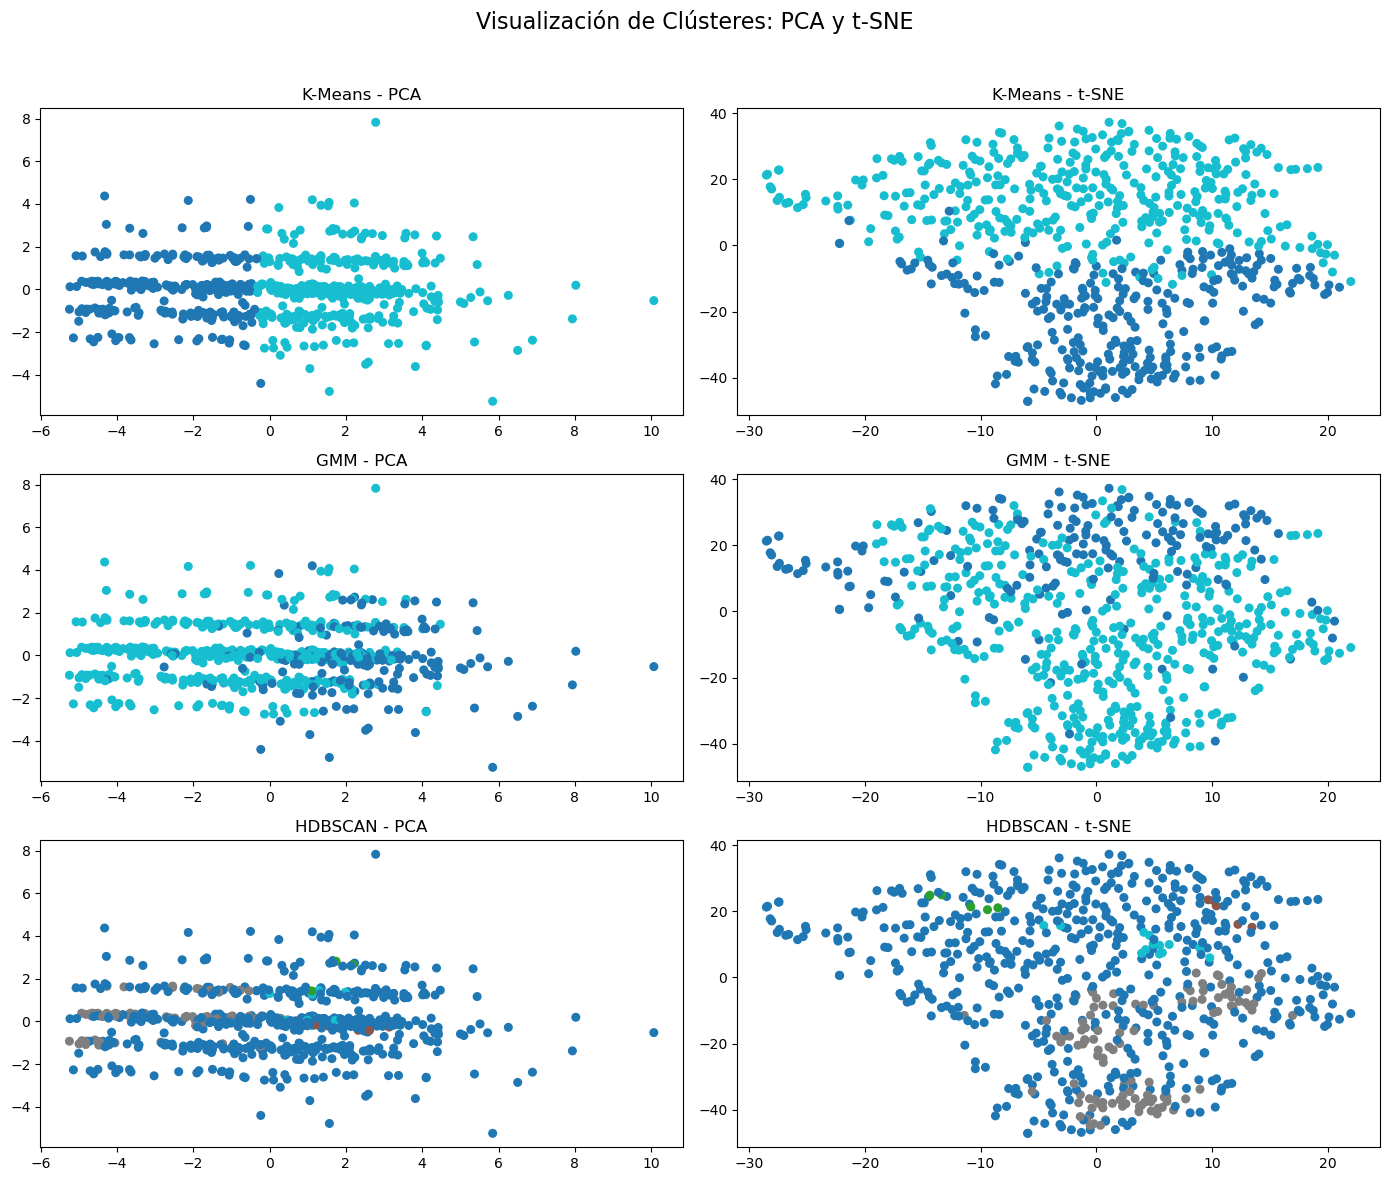

In [107]:
# --- APLICAR REDUCCIÓN DE DIMENSIONALIDAD CON PCA Y TSNE ---

# Usa los mismos datos escalados
# X debe estar definido de antes

pca_2d = PCA(n_components=2).fit_transform(X)
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X)

# Crear figura
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Visualización de Clústeres: PCA y t-SNE", fontsize=16)

# Lista de etiquetas
labels_dict = {
    'K-Means': labels_kmeans,
    'GMM': labels_gmm,
    'HDBSCAN': labels_hdbscan
}

# Colores por algoritmo
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Graficar para cada algoritmo
for idx, (metodo, etiquetas) in enumerate(labels_dict.items()):
    # PCA
    axs[idx][0].scatter(pca_2d[:, 0], pca_2d[:, 1], c=etiquetas, cmap='tab10', s=30)
    axs[idx][0].set_title(f'{metodo} - PCA')
    
    # t-SNE
    axs[idx][1].scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=etiquetas, cmap='tab10', s=30)
    axs[idx][1].set_title(f'{metodo} - t-SNE')

# Ajustar diseño
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


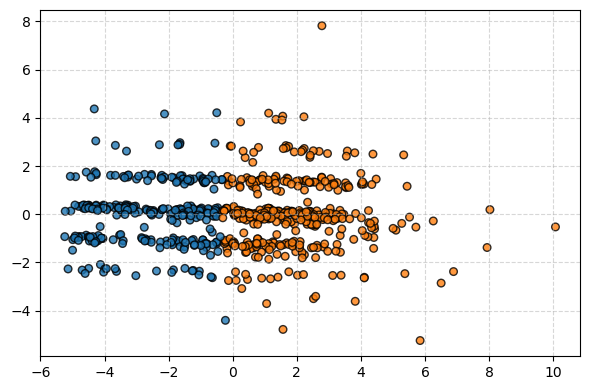

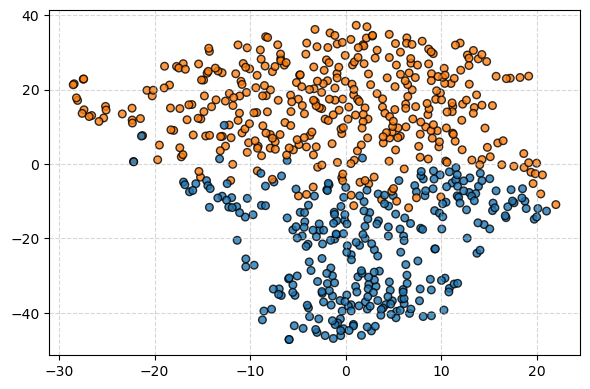

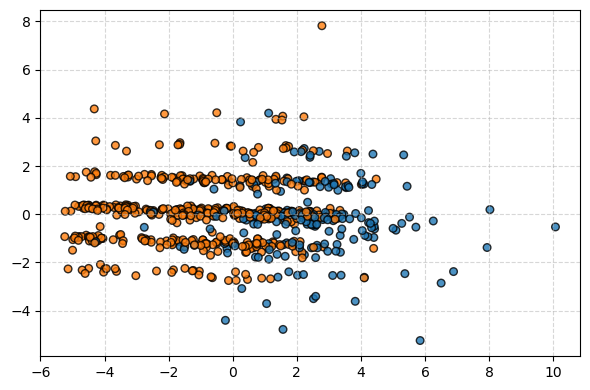

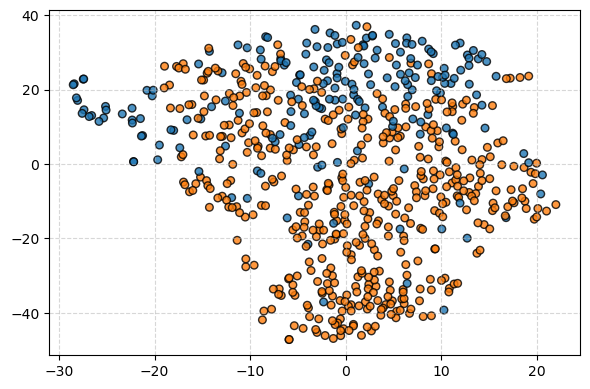

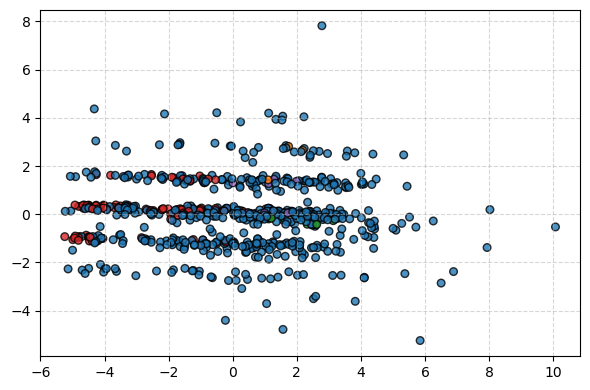

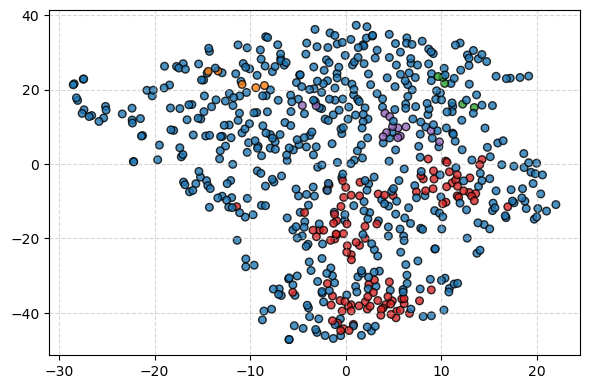

In [108]:
# --- SE GENERAN GRÁFICAS PARA EL TRABAJO ESCRITO --- 

# Crear carpeta si no existe
output_dir = "comparativa_grafica_pca_tsne"
os.makedirs(output_dir, exist_ok=True)

# Diccionario de etiquetas por método
labels_dict = {
    'K-Means': labels_kmeans,
    'GMM': labels_gmm,
    'HDBSCAN': labels_hdbscan
}

# Definir paleta de colores fija (hasta 10 clústeres)
colores_fijos = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

# Función para graficar
def graficar_metodo(metodo, etiquetas, datos_2d, tecnica, nombre_archivo):
    plt.figure(figsize=(6, 4))

    # Ajustar los colores según etiquetas únicas
    etiquetas_unicas = np.unique(etiquetas)
    colores = {etiqueta: colores_fijos[i % len(colores_fijos)] for i, etiqueta in enumerate(etiquetas_unicas)}
    colores_asignados = [colores[e] for e in etiquetas]

    # Graficar
    plt.scatter(datos_2d[:, 0], datos_2d[:, 1], c=colores_asignados, s=30, edgecolor='k', alpha=0.8)
    #plt.title(f"{metodo} - {tecnica}", fontsize=14)
    #plt.xlabel(f"{tecnica} 1")
    #plt.ylabel(f"{tecnica} 2")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Guardar imagen
    path = os.path.join(output_dir, nombre_archivo)
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

# Generar visualizaciones para cada método
for metodo, etiquetas in labels_dict.items():
    # PCA
    nombre_pca = f"{metodo.lower().replace('-', '_')}_pca.png"
    graficar_metodo(metodo, etiquetas, pca_2d, "PCA", nombre_pca)

    # t-SNE
    nombre_tsne = f"{metodo.lower().replace('-', '_')}_tsne.png"
    graficar_metodo(metodo, etiquetas, tsne_2d, "t-SNE", nombre_tsne)


In [109]:
# Crear copias del dataframe original para no alterar el original directamente
df_con_clusters = df.copy()

# Asegurar que las filas coincidan con las usadas en X
df_con_clusters = df_con_clusters.loc[df.index].reset_index(drop=True)

# Agregar columnas con los clústeres
df_con_clusters['cluster_kmeans'] = labels_kmeans
df_con_clusters['cluster_gmm'] = labels_gmm
df_con_clusters['cluster_hdbscan'] = labels_hdbscan


In [110]:
df_con_clusters["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0    295
1    383
Name: count, dtype: int64

In [111]:
df_con_clusters["cluster_gmm"].value_counts().sort_index()

cluster_gmm
0    197
1    481
Name: count, dtype: int64

In [112]:
df_con_clusters["cluster_hdbscan"].value_counts().sort_index()

cluster_hdbscan
-1    547
 0      5
 1      5
 2    108
 3     13
Name: count, dtype: int64

In [113]:
# --- OBTENER ESTADÍSTICAS DE LOS CLUSTERS GENERADOS ---

kmeans = KMeans(n_clusters=K, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(X)

# 1. Variables numéricas originales
num_cols = [
    'financiacion_total_por_acciones', 'ultima_financiacion_por_acciones',
    'monto_de_ultima_financiacion', 'financiacion_total',
    'seguidores_en_linkedin', 'seguidores_en_facebook', 'seguidores_en_twitter',
    'empleados_en_linkedin', 'años_desde_ultima_financiacion',
     'numero_de_marcas_registradas', 'numero_de_patentes_otorgadas',
    'numero_total_de_fundadores', 'numero_de_mujeres_fundadores',
    'numero_de_hombres_fundadores', 'numero_de_inversionistas',
    'numero_de_inversionistas_principales', 'numero_de_inversiones_en_rondas_de_financiacion',
    'numero_de_articulos', 'numero_de_rondas_de_financiacion'
]

# 2. Variables categóricas
cat_cols = ['categoria', 'tipo_de_ultima_financiacion']

# --- Estadísticas numéricas ---
media_por_cluster = df.groupby('cluster_kmeans')[num_cols].mean().round(2)
mediana_por_cluster = df.groupby('cluster_kmeans')[num_cols].median().round(2)

# --- Conteo por categoría ---
conteo_categorias = {}
for col in cat_cols:
    conteo = df.groupby('cluster_kmeans')[col].value_counts().unstack().fillna(0).astype(int)
    conteo_categorias[col] = conteo

# --- Mostrar resultados ---
print("📊 MEDIA por clúster:")
display(media_por_cluster)

print("\n📊 MEDIANA por clúster:")
display(mediana_por_cluster)

print("\n📊 CONTEO DE CATEGORÍAS por clúster:")
for var, tabla in conteo_categorias.items():
    print(f"\n🔸 {var.upper()}")
    display(tabla)


📊 MEDIA por clúster:


,financiacion_total_por_acciones,ultima_financiacion_por_acciones,monto_de_ultima_financiacion,financiacion_total,seguidores_en_linkedin,seguidores_en_facebook,seguidores_en_twitter,empleados_en_linkedin,años_desde_ultima_financiacion,numero_de_marcas_registradas,numero_de_patentes_otorgadas,numero_total_de_fundadores,numero_de_mujeres_fundadores,numero_de_hombres_fundadores,numero_de_inversionistas,numero_de_inversionistas_principales,numero_de_inversiones_en_rondas_de_financiacion,numero_de_articulos,numero_de_rondas_de_financiacion
cluster_kmeans,,,,,,,,,,,,,,,,,,,
0,1731655.25,1.323878e+06,1.323878e+06,1738687.0,2331.72,5881.86,104.43,14.85,5.21,0.29,0.18,2.19,0.32,1.87,5.17,1.46,0.00,6.29,2.24
1,36927681.36,5.814344e+09,5.814344e+09,38111256.6,17940.47,10523.01,211.21,125.10,3.14,0.85,1.03,2.41,0.31,2.10,15.24,3.00,0.02,28.80,4.61



📊 MEDIANA por clúster:


,financiacion_total_por_acciones,ultima_financiacion_por_acciones,monto_de_ultima_financiacion,financiacion_total,seguidores_en_linkedin,seguidores_en_facebook,seguidores_en_twitter,empleados_en_linkedin,años_desde_ultima_financiacion,numero_de_marcas_registradas,numero_de_patentes_otorgadas,numero_total_de_fundadores,numero_de_mujeres_fundadores,numero_de_hombres_fundadores,numero_de_inversionistas,numero_de_inversionistas_principales,numero_de_inversiones_en_rondas_de_financiacion,numero_de_articulos,numero_de_rondas_de_financiacion
cluster_kmeans,,,,,,,,,,,,,,,,,,,
0,1320000.0,665000.0,665000.0,1340000.0,779.0,4.0,0.0,8.0,4.88,0.0,0.0,2.0,0.0,2.0,4.0,1.0,0.0,2.0,2.0
1,19850000.0,15000000.0,15000000.0,20325000.0,6000.0,231.0,0.0,57.0,3.23,0.0,0.0,2.0,0.0,2.0,14.0,3.0,0.0,14.0,4.0



📊 CONTEO DE CATEGORÍAS por clúster:

🔸 CATEGORIA


categoria,Bienes Raíces y Construcción,Consumo,Educación,Finanzas,Industria,No Especificado,Salud,Software y Servicios B2B
cluster_kmeans,,,,,,,,
0,14,17,16,45,8,21,24,150
1,17,13,23,69,23,12,33,193



🔸 TIPO_DE_ULTIMA_FINANCIACION


tipo_de_ultima_financiacion,angel,pre_seed,seed,series_a,series_b
cluster_kmeans,,,,,
0,1,88,197,9,0
1,0,2,76,190,115


In [114]:
#--- OPCIONAL: ENCONTRAR POSIBLER OUTLIERES(VALORES EXTREMOS) EN LOS CLUSTERS ---

In [115]:
#Paso 1: Ver el tamaño de cada clúster
print("Distribución de clústeres:")
print(df['cluster_kmeans'].value_counts())

# Paso 2: Identificar el clúster con solo 1 elemento
cluster_unico = df['cluster_kmeans'].value_counts().idxmin()

# Paso 3: Extraer esa fila
outlier_row = df[df['cluster_kmeans'] == cluster_unico]
print("\n🔍 Posible outlier:")
display(outlier_row)

# Opcional: Ver estadísticas comparadas con el resto
print("\n📊 Comparativa con la media del resto:")
comparativa = pd.concat([
    outlier_row[num_cols].T.rename(columns={outlier_row.index[0]: 'Outlier'}),
    df[df['cluster_kmeans'] != cluster_unico][num_cols].mean().rename('Media_Otros')
], axis=1)
display(comparativa)

Distribución de clústeres:
cluster_kmeans
1    383
0    295
Name: count, dtype: int64

🔍 Posible outlier:


,nombre_de_la_empresa,fecha_de_fundacion,numero_de_marcas_registradas,numero_de_patentes_otorgadas,estado_operativo,categoria,antiguedad_de_la_empresa,empleados_en_linkedin,seguidores_en_linkedin,seguidores_en_facebook,...,financiacion_total_por_acciones_log,ultima_financiacion_por_acciones_log,monto_de_ultima_financiacion_log,financiacion_total_log,seguidores_en_linkedin_log,seguidores_en_facebook_log,seguidores_en_twitter_log,empleados_en_linkedin_log,años_desde_ultima_financiacion_log,cluster_kmeans
5,Rehook.ai,2019-12-01,0,0,active,Software y Servicios B2B,5,5.0,2000.0,0.0,...,14.457365,14.457365,14.457365,14.457365,7.601402,0.000000,0.000000,1.791759,1.453185,0
6,Milky Way AI,2019-12-01,0,0,active,Bienes Raíces y Construcción,5,3.0,724.0,0.0,...,12.409018,11.736077,11.736077,12.409018,6.586172,0.000000,0.000000,1.386294,1.581095,0
7,Laserfocus,2019-12-01,1,0,active,Software y Servicios B2B,5,2.0,307.0,0.0,...,13.132316,10.819798,10.819798,13.132316,5.730100,0.000000,0.000000,1.098612,1.826756,0
9,Webiny,2019-11-01,0,0,active,Software y Servicios B2B,5,13.0,858.0,0.0,...,15.194781,15.068274,15.068274,15.194781,6.755769,0.000000,0.000000,2.639057,1.588396,0
10,Rivet,2019-11-01,0,0,active,Software y Servicios B2B,5,3.0,393.0,0.0,...,13.122365,13.122365,13.122365,13.122365,5.976351,0.000000,0.000000,1.386294,1.183490,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,Lynks,2014-01-01,0,0,active,Consumo,11,36.0,2000.0,219.0,...,12.388398,11.695255,11.695255,12.388398,7.601402,5.393628,0.000000,3.610918,2.236621,0
673,LendEDU,2014-01-01,1,0,active,Bienes Raíces y Construcción,11,23.0,5000.0,904.0,...,11.849405,11.695255,11.695255,11.849405,8.517393,6.807935,0.000000,3.178054,2.332809,0
675,Placenote,2014-01-01,0,0,active,Software y Servicios B2B,11,2.0,2000.0,2000.0,...,14.220976,13.815512,13.815512,14.235675,7.601402,7.601402,0.000000,1.098612,2.424924,0
676,Lully,2014-01-01,1,0,active,Salud,11,10.0,253.0,11000.0,...,14.557448,14.557448,14.557448,14.557448,5.537334,9.305741,5.940171,2.397895,2.408302,0



📊 Comparativa con la media del resto:


,Outlier,6,7,9,10,12,13,14,15,16,...,668,669,670,671,672,673,675,676,677,Media_Otros
financiacion_total_por_acciones,1.900000e+06,245000.000000,505000.000000,3.972000e+06,500000.000000,190000.0,1.875000e+06,1.470000e+06,125000.000000,3.320000e+06,...,120000.000000,2.220000e+06,2.920000e+06,120000.00000,240000.000000,140000.000000,1.500000e+06,2.100000e+06,1.320000e+06,3.692768e+07
ultima_financiacion_por_acciones,1.900000e+06,125000.000000,50000.000000,3.500000e+06,500000.000000,85000.0,1.750000e+06,1.320000e+06,125000.000000,2.780000e+06,...,120000.000000,2.100000e+06,1.400000e+06,120000.00000,120000.000000,120000.000000,1.000000e+06,2.100000e+06,1.320000e+06,5.814344e+09
monto_de_ultima_financiacion,1.900000e+06,125000.000000,50000.000000,3.500000e+06,500000.000000,85000.0,1.750000e+06,1.320000e+06,125000.000000,2.780000e+06,...,120000.000000,2.100000e+06,1.400000e+06,120000.00000,120000.000000,120000.000000,1.000000e+06,2.100000e+06,1.320000e+06,5.814344e+09
financiacion_total,1.900000e+06,245000.000000,505000.000000,3.972000e+06,500000.000000,190000.0,1.875000e+06,1.470000e+06,125000.000000,3.320000e+06,...,120000.000000,2.220000e+06,2.920000e+06,120000.00000,240000.000000,140000.000000,1.522211e+06,2.100000e+06,1.320000e+06,3.811126e+07
seguidores_en_linkedin,2.000000e+03,724.000000,307.000000,8.580000e+02,393.000000,21000.0,6.900000e+02,1.660000e+02,2000.000000,2.000000e+03,...,135.000000,9.960000e+02,6.800000e+01,163.00000,2000.000000,5000.000000,2.000000e+03,2.530000e+02,6.000000e+01,1.794047e+04
seguidores_en_facebook,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,555.0,0.000000e+00,0.000000e+00,789.000000,0.000000e+00,...,0.000000,1.880000e+05,0.000000e+00,0.00000,219.000000,904.000000,2.000000e+03,1.100000e+04,7.570000e+02,1.052301e+04
seguidores_en_twitter,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,42.0,6.650000e+02,0.000000e+00,0.000000,6.910000e+02,...,468.000000,4.000000e+00,9.000000e+00,353.00000,0.000000,0.000000,0.000000e+00,3.790000e+02,2.730000e+02,2.112089e+02
empleados_en_linkedin,5.000000e+00,3.000000,2.000000,1.300000e+01,3.000000,73.0,2.300000e+01,2.000000e+00,12.000000,1.900000e+01,...,10.000000,6.000000e+00,4.000000e+00,17.00000,36.000000,23.000000,2.000000e+00,1.000000e+01,2.000000e+00,1.251044e+02
años_desde_ultima_financiacion,3.276712e+00,3.860274,5.213699,3.895890e+00,2.265753,1.8,4.783562e+00,4.810959e+00,3.860274,2.991781e+00,...,6.893151,9.764384e+00,9.701370e+00,9.90137,8.361644,9.306849,1.030137e+01,1.011507e+01,1.068219e+01,3.137516e+00
numero_de_marcas_registradas,0.000000e+00,0.000000,1.000000,0.000000e+00,0.000000,1.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.00000,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000e+00,8.459530e-01


In [116]:
# Crear carpeta si no existe
output_dir = "datasets_generados_por_modelado"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(output_dir+"/startups_con_clusters.csv", index=False)